# Tracking Plastic Using Ocean Parcels  

Find this as an intro into how to use Ocean Parcels to track plastic around Sulawesi Island, Indonesia. Once you've done the parcels tutorials and understand this you can start to change a few variables / add some things to the code.

More information can be found in the tutorials (https://oceanparcels.org/#tutorials) and the documentation (https://oceanparcels.org/gh-pages/html/).

## Loading the modules 

In python you need to 'load' in your modules to the environment your working in to be able to use the commands and functions in a module. You do not have to edit this part of the code.

You may need to download some modules if you don't have them already, you will get an error saying hte module doesn't exist if you haven't installed it yet. To do this go to your Anaconda prompt and type in the following example code:

    conda activate py3_parcels 
    conda install xarray # change the 'xarray' to what is missing

In [1]:
%matplotlib inline 
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, Field, ScipyParticle, ErrorCode
import numpy as np 
import math 
from datetime import timedelta
from datetime import timedelta as delta
from operator import attrgetter 
import os 
from glob import glob
from os import path
import xarray as xr 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.animation as animation
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=UserWarning)

## FieldSet 

The HYCOM model is an example of an ocean model supported by Parcels, which allows it to read in the two- and three- dimensional fields of the model output fairly easily.

HYCOM outputs are stored in NetCDF files (.nc). It is a file format used for storing multidimensional scientific variables.

The following code block creates a 3 dictionaries (a popular Python datatype) called filenames, variables and dimensions. Dictionaries are written in something called 'key:value pairs'. The name of the variable is the key and the data is the value. You can stored multiple key:value pairs in the same dictionary. This allows OceanParcels to access the name of the variable and the data that are stored in the netCDF file.

In [2]:
filenames = {'U':sorted(glob('hycom/wet_season_20202021/*.nc4')),
            'V':sorted(glob('hycom/wet_season_20202021/*.nc4'))}

variables = {'U':'water_u',
            'V':'water_v'}

dimensions = {'lat':'lat',
             'lon':'lon',
             'time':'time'}

The first step to be able to run your particles is define a FieldSet object which holds the hydrodynamic fields. We use the FieldSet.from_netcdf function here since OceanParcels can automatically read NetCDF files.

In [3]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, vmin=-2000,allow_time_extrapolation=True)

## ParticleSet

The next step is to define a ParticleSet, a class used for setting up and storing the information related to the particles. Its currently using a single longtiude and latitude value to release a particular number of particles from. You can release the particles in other patterns too (e.g locations from a given list). Check the documentation on the parcels website for the other options.

You can change the number of particles (e.g the variable, npart) and the longitude and latitude (e.g the lon and lat variables) from where you would like the particles to be released. 

Warning: Be careful where you release your particles. If you release them on or too close to the land the ocean currents won't pick them up and they will get stuck! 

In [10]:
npart = 80  # number of particles to be released
lon = [124.8] * npart
lat = [1.72] * npart 
repeatdt = delta(hours=24)  # release from the same set of locations every 24 hours

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, repeatdt=repeatdt)

Print the ParticleSet to see where they start

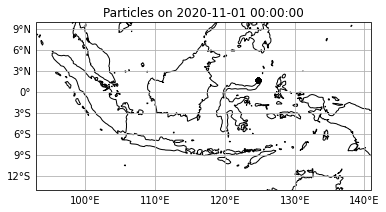

In [5]:
pset.show()

The model will fail if the particle floats outside of the HYCOM bounday. This function removes the particle once it hits the model boundary.

In [6]:
def DeleteParticle(particle,fieldset,time):
    particle.delete()

## Running the model 

Now its time to run the model by running the pset.execute function and save the results to the NetCDF called "filename.nc". 

You can change the name of the results file, while also changing the total length of the run. 

In [11]:
output_file = pset.ParticleFile(name="filename.nc", outputdt=timedelta(hours=6)) # the file name and the time step of the outputs

kernels = pset.Kernel(AdvectionRK4) #AdvectionRK4_3D advect the particles using the AdvectionRK4_3D kernel. This needs to happen before the next line. 
pset.execute(kernels,              
             runtime=delta(days=21), # total length of the run 
             dt=delta(hours=3),     # the timestep of the kernel 
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/15/vlf1ck6j1xj7ttfxgkgqvbw40000gn/T/parcels-501/lib4d737c8e586fd1ec536f70d294b0bcbf_0.so


Show the end locations of the particles

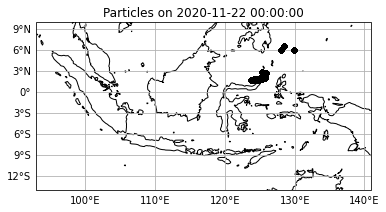

In [12]:
pset.show() 